<a href="https://colab.research.google.com/github/TWBanana/CS652/blob/master/CS652_Project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing packages.

In [4]:
import pickle
import random
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.decomposition import PCA
from sklearn.utils import class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import log_loss, accuracy_score, roc_auc_score, matthews_corrcoef

random.seed(42)
np.random.seed(42)
random_state = 42

* Connecting google drive with colab.
* Changing the directory to where the data set is located.
* There are several causes in the dataset, the only cause we are going to evaluate is "DDoS".

In [5]:
# Global Parameters
DATA_FOLDER = "/content/drive/My Drive/blog_ddos_detection-master/data_100/"
LABEL_FILENAME = "/content/drive/My Drive/blog_ddos_detection-master/internet_disruptions.tsv"
CAUSES = ["Natural Disaster",
          "DDoS",
          "Power Outage",
          "BGP Update",
          "Misconfiguration",
          "Cable Cut",
          "none"]
CAUSE_INDEX = 1     # which cause to evaluate
DATA_LIMIT = 75     # how many countries/cities/organizations to use (max 100)
TRIALS = 50         # trials
STEP = 3            # ensures no poisoning of results (DO NOT CHANGE)
PCA_DIM = 40        # projection dimension (should be <= DATA_LIMIT)

* Function to check if the cause is DDoS it will return positive, else return negative.
* Make every character into lower case in this column.


In [6]:
def process_cause(x):
    if CAUSES[CAUSE_INDEX].lower() in x.lower():
        return "positive_class"
    return "negative_class"

**Preprocess the data**

* Since we only need two columns of data, "common name" and "cause".
* We'll need to do data cleaning, which is to drop the null value.
* We restore the dictionary with some values in "common name" starts with "before_" and replace it's "cause" with "none".
* Using the function "process_cause" to seperate the data into positive_class and negative_class. 
* Create new list lbl, for every key in the keep_keys, if value in "common name" matches key. Then, store this value's index[0], which is "positive_class" in the list lbl.
* We us the pickle to load the data and seperate into X and list Y list.
* Finally, we randomize the data for futhur training and testing.

In [15]:
def preprocess_data(data_folder=DATA_FOLDER,
                    label_filename=LABEL_FILENAME,
                    data_limit=DATA_LIMIT):
    nides = pd.read_csv(label_filename, sep="\t")[["common name", "cause"]].dropna()

    # If "before_" in "common name",  store "cause" with "none".
    for key in nides["common name"].values:
        nides = nides.append({"common name":f"before_{key}","cause":"none"}, ignore_index=True)

    # Using the proceess_cause function to seperate if it's DDoS or not.
    nides["cause"] = nides.cause.apply(process_cause)
    keep_keys = [key for key,value in Counter(nides.cause.values).items()]
    keep_keys = list(nides[nides.cause.isin(keep_keys)]["common name"].values.ravel())
    nides = nides[nides["common name"].isin(keep_keys)]
    
    # create new list lbl, and store "positive_class" cause.
    lbl = [] 
    for key in keep_keys:
        cause = nides[nides["common name"] == key].cause.values[0]
        lbl.append(cause)
    

    y = np.zeros((len(lbl)),dtype=int)
    
    # Create new list y, for every value in lbl, if value = "positive_class", store 1 to y, else store 0.
    for i, cause in enumerate(set(lbl)):
        y[np.where(np.array(lbl)==cause)[0]] = i
    
    X = []
    Y = []
    print(keep_keys)
    for i,key in enumerate(sorted(keep_keys)):
        try:
            tmp = pickle.load(open(f"{data_folder}{key}_100.attr", "rb"))
            [X.append(tmp[j].values.T[:,:data_limit]) for j in range(3)]
            [Y.append(y[i]) for j in range(3)]
        except Exception as e:
            continue

    data_full = np.array(X)

    data_labels = np.vstack(Y).ravel()

    #  Randomize the data for futhur training and testing.
    data_pos = data_full[data_labels == 1]
    data_neg = data_full[data_labels == 0]
    np.random.shuffle(data_pos)
    np.random.shuffle(data_neg)
    min_len = np.min([len(data_pos), len(data_neg)])
    X = np.vstack([data_pos[:min_len], data_neg[:min_len]])
    y = np.vstack([np.ones((min_len,1)),np.zeros((min_len,1))])
    return X,y

From the result, we can know that the model accuracy is between 80%~100% and the standard diviation is between +6% and -6%. By using this model, the accuratcy of testing the data is 85% and the standard diviation is between +9% and -9%. As the result of both model accuracy and testing performance are high. So, we can say that this testing result is reliable.

In [ ]:
# Function to display the result and visualization.
def display_results(acc_test,auc_test,mcc_test):
    print("mean +/- std [min, max]")
    print(f"{np.round(np.mean(acc_test),4)} +/- {np.round(np.std(acc_test),4)} [{np.round(np.min(acc_test),4)}-{np.round(np.max(acc_test),4)}]")
    print(f"{np.round(np.mean(auc_test),4)} +/- {np.round(np.std(auc_test),4)} [{np.round(np.min(auc_test),4)}-{np.round(np.max(auc_test),4)}]")
    print(f"{np.round(np.mean(mcc_test),4)} +/- {np.round(np.std(mcc_test),4)} [{np.round(np.min(mcc_test),4)}-{np.round(np.max(mcc_test),4)}]")

    plt.figure(figsize=(15,5))
    data = np.hstack([np.array(acc_test)[:,None],np.array(auc_test)[:,None],np.array(mcc_test)[:,None]])
    df = pd.DataFrame(data,columns=["Test Accuracy","Test AUC","Test Matthew Correlation Coefficient"])
    sb.boxplot(data=df, orient="h")
    plt.title("Detecting Denial-of-Service Attacks\nDistribution of Metrics on Test Set")
    plt.show()

mean +/- std [min, max]
0.8683 +/- 0.0973 [0.5833-1.0]
0.9519 +/- 0.0623 [0.7778-1.0]
0.7662 +/- 0.1682 [0.3015-1.0]


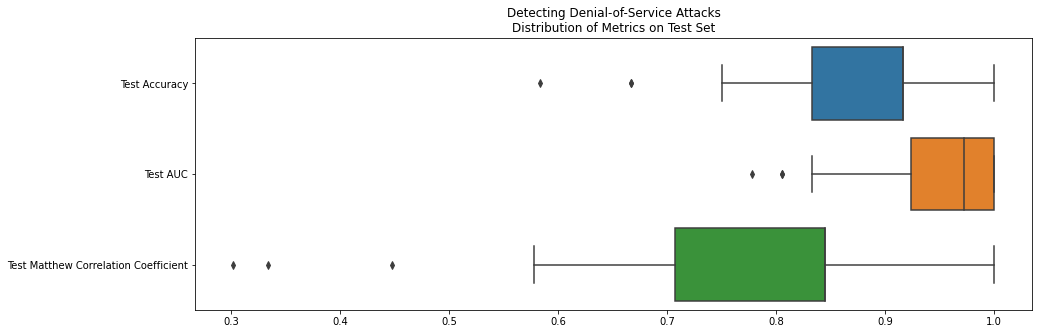

In [ ]:
display_results(acc_test,auc_test,mcc_test)

**Training and Testing**

* Using the function "preprocess_data" to get the value store in X and y.
* Create three list for storing the results.
* First, we seperate the data into training and testing. Then, we apply PCA model to reduce the dimensions of the data into only feature column.
* Finally, we apply Random forest model on both training and testing data to get the result.

In [ ]:
# Start of Evaluation
X,y = preprocess_data()

auc_test = []
acc_test = []
mcc_test = []

for trial in range(TRIALS):

    # split the data into training and testing.
    index = list(range(0, len(X), STEP))
    indices = list(StratifiedShuffleSplit(n_splits=1, test_size=.15).split(index, y[::STEP]))
    train_idx = indices[0][0]
    test_idx = indices[0][1]
    train_idx = np.array([[index[i], index[i]+1, index[i]+2] for i in train_idx]).ravel()
    test_idx = np.array([[index[i], index[i]+1, index[i]+2] for i in test_idx]).ravel()
    x_train = X[train_idx]
    x_test = X[test_idx]
    y_train = y[train_idx].ravel()
    y_test = y[test_idx].ravel()

    #  Reducing the dimension of data into only feature column.
    for i in range(len(x_train)):
        x_train[i] = np.divide(x_train[i], np.expand_dims(np.max(x_train[i], axis=-1)+1E-3, axis=-1))
    for i in range(len(x_test)):
        x_test[i] = np.divide(x_test[i], np.expand_dims(np.max(x_test[i], axis=-1)+1E-3, axis=-1))
    x_train = x_train - 0.5
    x_test = x_test - 0.5

    pca = PCA(n_components=PCA_DIM)
    pca.fit(np.squeeze(np.mean(x_train, axis=-1)))
    pca_x_train = pca.transform(np.squeeze(np.mean(x_train, axis=-1)))
    pca_x_test = pca.transform(np.squeeze(np.mean(x_test, axis=-1)))

    print(f"Baseline 1:  {accuracy_score(y_test, np.zeros(len(y_test)))}\n")


    # Using random forest package to train and test the model.
    model = RandomForestClassifier(n_estimators=1000, max_depth=35)
    model.fit(pca_x_train, y_train)

    print(f"Test Accuracy: {accuracy_score(y_test, model.predict(pca_x_test))}")
    print(f"Test AUC:      {roc_auc_score(y_test, model.predict_proba(pca_x_test)[:,1])}")
    print(f"Test Log-Loss: {log_loss(y_test, model.predict_proba(pca_x_test)[:,1])}")
    print(f"Test MCC:      {matthews_corrcoef(y_test, model.predict(pca_x_test))}\n")
  

    acc_test.append(accuracy_score(y_test, model.predict(pca_x_test)))
    auc_test.append(roc_auc_score(y_test, model.predict_proba(pca_x_test)[:,1]))
    mcc_test.append(matthews_corrcoef(y_test, model.predict(pca_x_test)))